## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset, Subset
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = FashionMNIST(root_path, 
                                    train=True, 
                                    transform=train_transform,
                                    target_transform=None,
                                    download=download)
fmnist_dataset_test = FashionMNIST(root_path,
                                   train=False,
                                   transform=test_transform,
                                   target_transform=None,
                                   download=download)

In [4]:
train_loader = DataLoader(fmnist_dataset_train, 
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
test_loader = DataLoader(fmnist_dataset_test,
                         batch_size=256,
                         shuffle=False,
                         num_workers=2)

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [5]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, num_classes),
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

Your experiments come here:

In [6]:
model = TinyNeuralNetwork().to(device, torch.float32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [7]:
torchsummary.summary(model.to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
       BatchNorm1d-3                  [-1, 100]             200
              ReLU-4                  [-1, 100]               0
           Dropout-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
Total params: 79,710
Trainable params: 79,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


In [8]:
def train_model(model, train_loader, test_loader, loss, opt, n_epochs: int):
    '''
    model: нейросеть для обучения
    train_loader: загрузчик данных
    loss: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    test_loss = []
    test_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_test_loss = []
        ep_test_accuracy = []

        model.train(True)
        for X_batch, y_batch in train_loader:

            opt.zero_grad()

            predictions = model(X_batch.to(device))
            loss_value = loss(predictions, y_batch.to(device))
            loss_value.backward()
            opt.step()

            ep_train_loss.append(loss_value.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in test_loader:

                predictions = model(X_batch.to(device))
                loss_value = loss(predictions, y_batch.to(device))

                y_pred = (torch.argmax(predictions, dim=1)).to('cpu')
                accuracy = (y_batch == y_pred).float().mean()

                ep_test_loss.append(loss_value.item())
                ep_test_accuracy.append(accuracy)

        train_loss.append(np.mean(ep_train_loss))
        test_loss.append(np.mean(ep_test_loss))
        test_accuracy.append(np.mean(ep_test_accuracy))

        print(f"{epoch} epoch results:")
        print(f"\t training loss: {train_loss[-1]:.6f}")
        print(f"\t test loss: {test_loss[-1]:.6f}")
        print(f"\t test accuracy: {test_accuracy[-1]:.3f}")

    return train_loss, test_loss, test_accuracy

In [9]:
train_loss, test_loss, test_accuracy = train_model(model, train_loader, test_loader, loss_func, optimizer, 20)

0 epoch results:
	 training loss: 0.527346
	 test loss: 0.420299
	 test accuracy: 0.848
1 epoch results:
	 training loss: 0.380134
	 test loss: 0.408355
	 test accuracy: 0.856
2 epoch results:
	 training loss: 0.345709
	 test loss: 0.391198
	 test accuracy: 0.861
3 epoch results:
	 training loss: 0.319973
	 test loss: 0.351573
	 test accuracy: 0.871
4 epoch results:
	 training loss: 0.305246
	 test loss: 0.346033
	 test accuracy: 0.874
5 epoch results:
	 training loss: 0.291047
	 test loss: 0.369176
	 test accuracy: 0.867
6 epoch results:
	 training loss: 0.277705
	 test loss: 0.335264
	 test accuracy: 0.878
7 epoch results:
	 training loss: 0.268385
	 test loss: 0.357989
	 test accuracy: 0.871
8 epoch results:
	 training loss: 0.257749
	 test loss: 0.358413
	 test accuracy: 0.867
9 epoch results:
	 training loss: 0.251026
	 test loss: 0.355624
	 test accuracy: 0.871
10 epoch results:
	 training loss: 0.241453
	 test loss: 0.334911
	 test accuracy: 0.882
11 epoch results:
	 training lo

In [10]:
def plot_train_process(train_loss, test_loss, test_accuracy, required_acc=False):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(test_loss, label='test')
    axes[0].legend()

    axes[1].set_title('Test accuracy')
    axes[1].plot(test_accuracy)
    if required_acc:
        axes[1].plot([0.885] * len(test_accuracy))

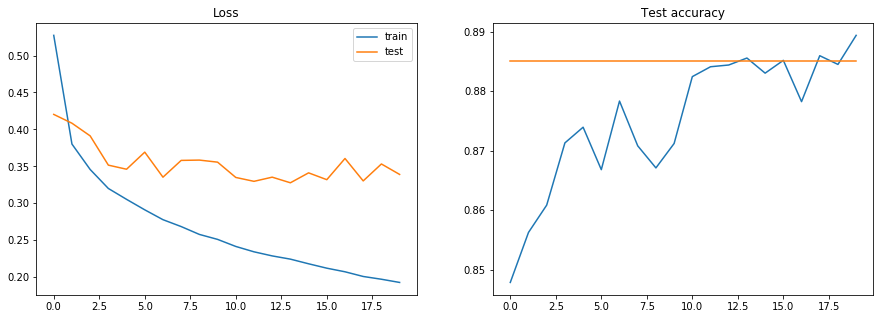

In [11]:
plot_train_process(train_loss, test_loss, test_accuracy, True)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [14]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [15]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 100]          50,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
Total params: 443,610
Trainable params: 443,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.69
Estimated Total Size (MB): 1.71
----------------------------------------------------------------


In [16]:
over_model = OverfittingNeuralNetwork().to(device, torch.float32)
optimizer = torch.optim.Adam(over_model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [17]:
over_train_loss, over_test_loss, over_test_accuracy = train_model(over_model, train_loader, test_loader, loss_func, optimizer, 20)

0 epoch results:
	 training loss: 0.553455
	 test loss: 0.415773
	 test accuracy: 0.850
1 epoch results:
	 training loss: 0.376212
	 test loss: 0.376330
	 test accuracy: 0.866
2 epoch results:
	 training loss: 0.335655
	 test loss: 0.389762
	 test accuracy: 0.861
3 epoch results:
	 training loss: 0.310235
	 test loss: 0.361568
	 test accuracy: 0.868
4 epoch results:
	 training loss: 0.293082
	 test loss: 0.344192
	 test accuracy: 0.875
5 epoch results:
	 training loss: 0.273656
	 test loss: 0.344420
	 test accuracy: 0.877
6 epoch results:
	 training loss: 0.262445
	 test loss: 0.329680
	 test accuracy: 0.886
7 epoch results:
	 training loss: 0.249566
	 test loss: 0.341399
	 test accuracy: 0.880
8 epoch results:
	 training loss: 0.240842
	 test loss: 0.339175
	 test accuracy: 0.886
9 epoch results:
	 training loss: 0.228497
	 test loss: 0.328648
	 test accuracy: 0.885
10 epoch results:
	 training loss: 0.220153
	 test loss: 0.327788
	 test accuracy: 0.885
11 epoch results:
	 training lo

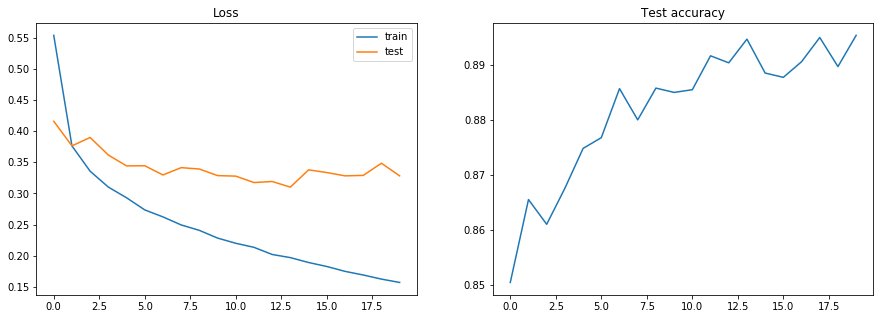

In [18]:
plot_train_process(over_train_loss, over_test_loss, over_test_accuracy)

![overfitting](https://raw.githubusercontent.com/lwtztea/freelance/master/picture.jpg)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [19]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(p=0.1),
            nn.Linear(100, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [20]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
           Dropout-4                  [-1, 500]               0
            Linear-5                  [-1, 100]          50,100
              ReLU-6                  [-1, 100]               0
       BatchNorm1d-7                  [-1, 100]             200
           Dropout-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
Total params: 443,810
Trainable params: 443,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.69
Estimated Total Size (MB): 1.72
-------------------------------------------

In [21]:
fixed_model = FixedNeuralNetwork().to(device, torch.float32)
optimizer = torch.optim.Adam(fixed_model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [22]:
fixed_train_loss, fixed_test_loss, fixed_test_accuracy = train_model(fixed_model, train_loader, test_loader, loss_func, optimizer, 20)

0 epoch results:
	 training loss: 0.626525
	 test loss: 0.440451
	 test accuracy: 0.841
1 epoch results:
	 training loss: 0.480819
	 test loss: 0.408828
	 test accuracy: 0.853
2 epoch results:
	 training loss: 0.442334
	 test loss: 0.386056
	 test accuracy: 0.863
3 epoch results:
	 training loss: 0.425626
	 test loss: 0.375551
	 test accuracy: 0.863
4 epoch results:
	 training loss: 0.409443
	 test loss: 0.378246
	 test accuracy: 0.861
5 epoch results:
	 training loss: 0.397288
	 test loss: 0.368197
	 test accuracy: 0.868
6 epoch results:
	 training loss: 0.386439
	 test loss: 0.356197
	 test accuracy: 0.870
7 epoch results:
	 training loss: 0.376846
	 test loss: 0.347999
	 test accuracy: 0.873
8 epoch results:
	 training loss: 0.370611
	 test loss: 0.349755
	 test accuracy: 0.873
9 epoch results:
	 training loss: 0.360088
	 test loss: 0.345249
	 test accuracy: 0.877
10 epoch results:
	 training loss: 0.355741
	 test loss: 0.336340
	 test accuracy: 0.879
11 epoch results:
	 training lo

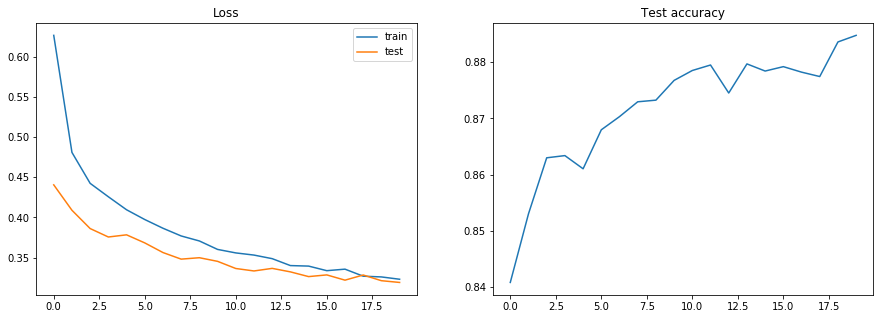

In [23]:
plot_train_process(fixed_train_loss, fixed_test_loss, fixed_test_accuracy)

$\textbf{Вывод: }$ Когда, казалось бы, ситуация уже совсем безнадёжна и loss на тестовой выборке не опускается с самого начала обучения, просто вспомните про dropout и batchnorm!